# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

## Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Примечания:

Для оценки качества моделей применяйте метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.
Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

#### Признаки

DateCrawled — дата скачивания анкеты из базы
VehicleType — тип автомобильного кузова
RegistrationYear — год регистрации автомобиля
Gearbox — тип коробки передач
Power — мощность (л. с.)
Model — модель автомобиля
Kilometer — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива
Brand — марка автомобиля
Repaired — была машина в ремонте или нет
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя

#### Целевой признак

Price — цена (евро)

## План работы

1. Загрузить данные и провести предобработку.
2. Выполнить сравнение моделей с использованием различных наборов гиперпараметров.
3. Выбрать лучшую модель по результатам метрики RMSE и времени обучения.
4. Написать выводы.

## Подготовка данных

In [1]:
import sys
!{sys.executable} -m pip install lightgbm

In [2]:
conda install lightgbm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.2
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
import lightgbm
import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,f_regression


In [4]:
data = pd.read_csv('/datasets/autos.csv')
display(data.head())#прочитаем датафрейм и выведим 5 строк

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()#посмотрим тип значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe(include = "all")#посмотрим на статистическую сводку по каждому столбцу

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


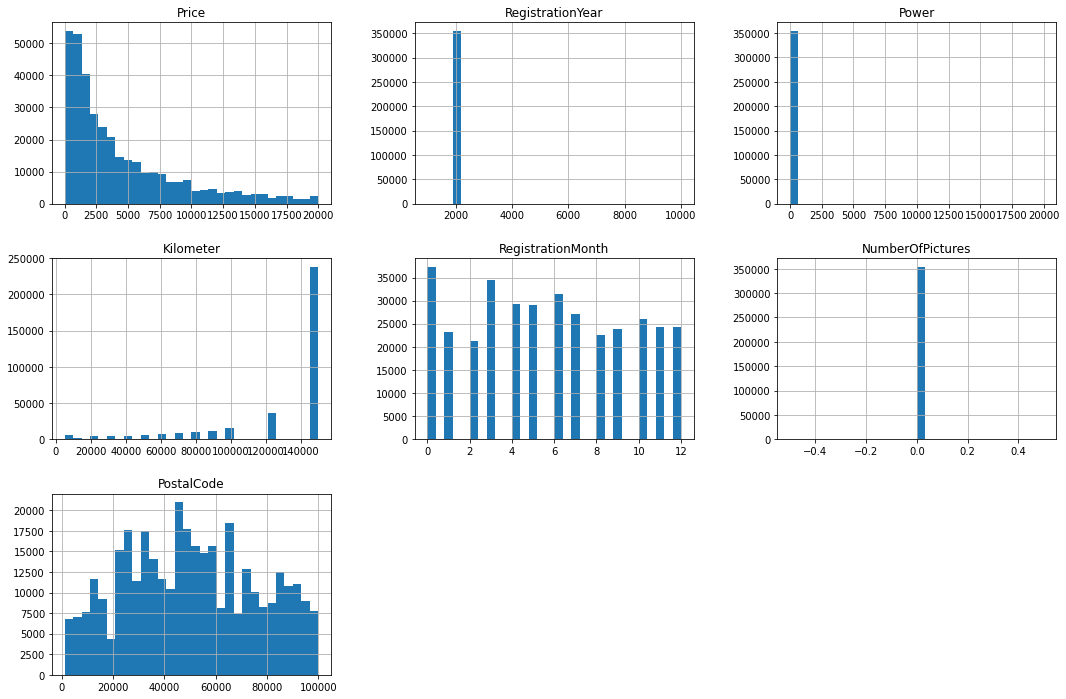

In [7]:
digital_features=data.select_dtypes(exclude=['object'])#построим гистограммы для числовых признаков
digital_features.hist(figsize=(18,12), bins=30)
plt.show()

___Комментарии:___ Нам предоставлены данные о технических характеристиках автомобилей, данных состоят из 16 столбцов, 9 из них составляют тип объекта, остальные количественные переменные, 354369 строк. Данные содержат пропуски в некоторых столбцах. Целевой признак - цена, среднее значение которого 4416 евро. Стобец мощность автомобиля(power) и год регистрации автомобиля (registrationyear) содержит аномальные значения, которые надо обработать. Далее обработаем пропуски, дубликаты и аномалии.

In [8]:
data.nunique()#посмотрим какое количество уникальных значений в каждом столбце

DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

In [9]:
data.duplicated().sum()#проверим наличие дубликатов

4

In [10]:
data = data.drop_duplicates().reset_index(drop=True)#удалим дубликаты

In [11]:
data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')#проверим пропуски

,0
DateCrawled,0.00%
Price,0.00%
RegistrationYear,0.00%
Power,0.00%
Kilometer,0.00%
RegistrationMonth,0.00%
Brand,0.00%
DateCreated,0.00%
NumberOfPictures,0.00%
PostalCode,0.00%


In [12]:
data.columns = data.columns.str.lower()#приведем к нижнему регистру данные

In [13]:
data_1 = data.iloc[:, [i for i, n in enumerate(np.var(data.isnull(), axis = 'rows')) if n > 0]]
data_1.isnull().corr()#посмотрим на корреляцию пропущенных значений в столбцах

,vehicletype,gearbox,model,fueltype,repaired
vehicletype,1.000000,0.314202,0.189907,0.436778,0.298731
gearbox,0.314202,1.000000,0.162228,0.299482,0.269864
model,0.189907,0.162228,1.000000,0.226342,0.156694
fueltype,0.436778,0.299482,0.226342,1.000000,0.242166
repaired,0.298731,0.269864,0.156694,0.242166,1.000000


___Комментарии:___ У нас низкая корреляция между признаками, мы видим что взаимозвязь между ними слабая. Пропуски одного значения не влияют на пропуски другого. Заменим значения пропущенных значений в столбцах пустым значением, кроме столбца тип автомобильного кузова, его заменим на часто встречающуюся модель кузова в данном столбце.

In [14]:
data['model'] = data['model'].fillna(value = 'uknow')#заменим пустые значение строковым значением
data['gearbox'] = data['gearbox']. fillna(value = 'uknow')
data['fueltype'] = data['fueltype'].fillna(value = 'uknow')
data['repaired'] = data ['repaired'].fillna(value = 'uknow')

In [15]:
data['vehicletype'].value_counts()#проверим какие значения чаще всего встречаются

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicletype, dtype: int64

In [16]:
data['vehicletype'].replace(np.nan, 'sedan', inplace = True)#заменим пропущенные значения в столбце значением sedan, который чаще встречается
data['vehicletype'].describe()#проверим что sedan остался топовым значением

count     354365
unique         8
top        sedan
freq      128947
Name: vehicletype, dtype: object

In [17]:
data.isna().sum()#проверим что пропуски отработаны

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
repaired             0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

In [18]:
data['power'].unique()#посмотрим на уникальные значения

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

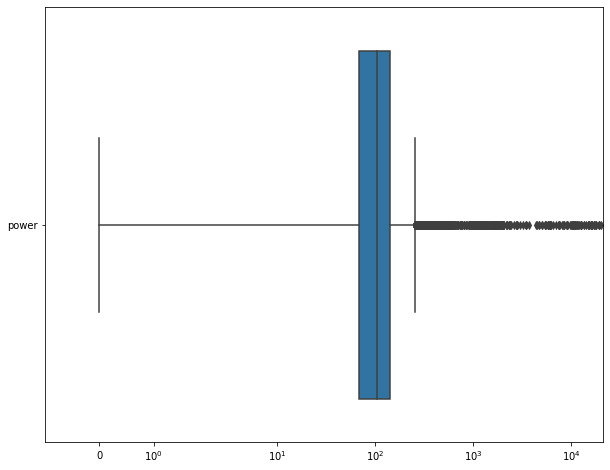

In [19]:
plt.figure(figsize=(10, 8))#построим диаграмму размаха
sns.boxplot(data=data[['power']], orient='h')
plt.xscale('symlog')
plt.xlim(left=-1)
plt.show()

___Комментарии:____ В столбце мощность автомобиля, мы выдим выбросы. Эти аномальные значения обработаем с помощью логического оператора. Год регистрации автомобиля также есть аномальные значения, отбросим их. 

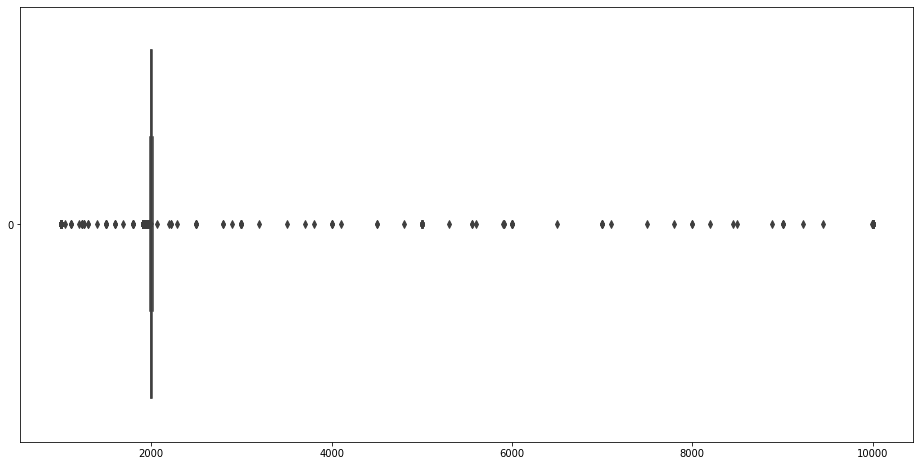

In [20]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=data.registrationyear, orient='h')
plt.show()

In [21]:
data.sort_values(by='registrationyear', axis=0, ascending=True).head()#посмотрим на минимальное значение года регистрации автомобиля

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
66198,2016-03-08 14:50:20,1300,sedan,1000,auto,0,uknow,5000,6,petrol,sonstige_autos,uknow,2016-03-08 00:00:00,0,13156,2016-03-17 08:17:42
183778,2016-03-08 14:56:03,500,sedan,1000,uknow,0,uknow,5000,1,uknow,sonstige_autos,uknow,2016-03-08 00:00:00,0,26203,2016-03-09 22:45:54
323440,2016-03-26 20:58:27,30,sedan,1000,uknow,0,uknow,5000,0,uknow,audi,uknow,2016-03-26 00:00:00,0,37574,2016-04-06 12:17:27
174892,2016-03-05 19:48:45,0,sedan,1000,uknow,1000,golf,5000,4,petrol,volkswagen,uknow,2016-03-05 00:00:00,0,35716,2016-03-05 22:27:55
97736,2016-03-14 11:37:04,140,sedan,1000,uknow,0,911,5000,0,uknow,porsche,uknow,2016-03-14 00:00:00,0,88630,2016-03-17 22:16:17


In [22]:
data = data[(data['registrationyear']>1980)&(data['registrationyear']<2017)]#с помощью лог.оператора перезапишем датафрейм
print(data['registrationyear'].unique())

[1993 2011 2004 2001 2008 1995 2014 1998 2005 2016 2007 2009 2002 1997
 1990 1981 2003 1994 1991 1984 2006 1999 2012 2010 2000 1992 2013 1996
 1985 1989 2015 1982 1983 1987 1986 1988]


In [23]:
data.loc[data.power > 1600, 'power'] = data['power'] / 100 #поделим и умножим аномальные значения мощности автомобиля
data.loc[data.power < 50, 'power'] = data['power'] * 10
data.loc[data.power == 0, 'power'] = data['power'] + 80
data['power'] = data['power'].astype('int')
data['power'] = data.reindex(['power'], axis=1) 

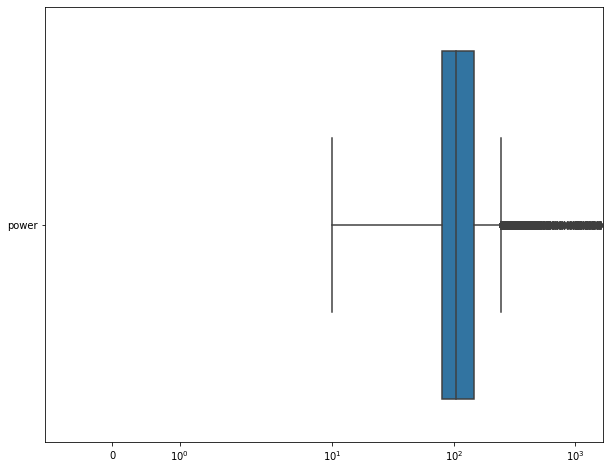

In [24]:
plt.figure(figsize=(10, 8))#проверим аномальные выбросы на диаграмме размаха
sns.boxplot(data=data[['power']], orient='h')
plt.xscale('symlog')
plt.xlim(left=-1)
plt.show()

___Вывод:___ Мы познакомились с данными о технических характеристиках, комплектации и ценах на автомобили. Обработали пропущенные значения, аномалии в некоторых столбцах, перевели некоторые данные в объект дату, чтобы можно было делать математические операции.

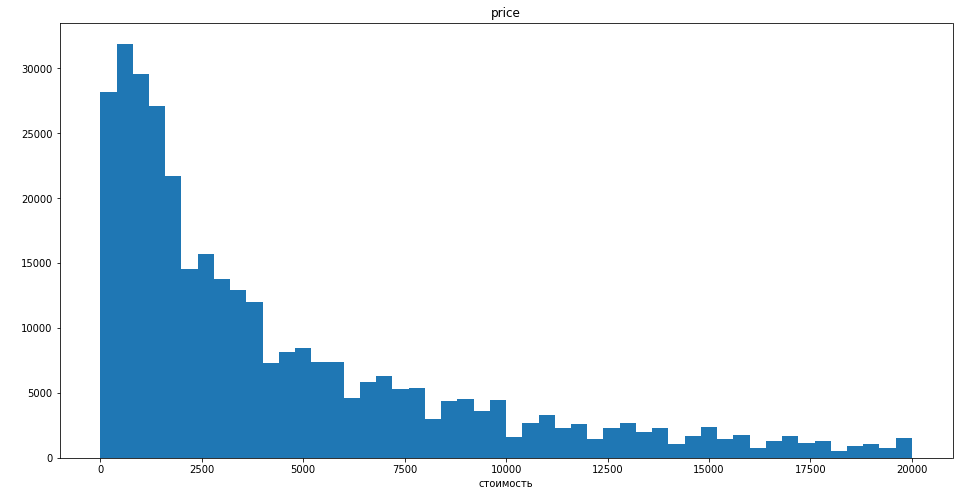

In [25]:
plt.figure(figsize=(16, 8))
plt.title('price')
plt.hist(data['price'], bins=50)
plt.xlabel('стоимость')
plt.ylabel(' ')
plt.show()

In [26]:
data = data.query('price>500')
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,296458.000000,296458.000000,296458.000000,296458.000000,296458.000000,296458.0,296458.000000
mean,5007.487546,2003.340733,124.521828,128085.799675,5.988005,0.0,51087.161476
std,4532.814321,5.791656,64.276954,36921.821518,3.614862,0.0,25681.194203
min,501.000000,1981.000000,10.000000,5000.000000,0.000000,0.0,1067.000000
25%,1500.000000,2000.000000,80.000000,125000.000000,3.000000,0.0,30890.000000
50%,3350.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,50127.000000
75%,7000.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,71642.000000
max,20000.000000,2016.000000,1600.000000,150000.000000,12.000000,0.0,99998.000000


## Обучение моделей

### Подготовка выборки для обучения моделей

Поскольку модель может переобучиться, мы удалим некоторые столбцы из датафрейма, которые приравниваются к идентификатору

In [27]:
data = data.drop(columns=['datecrawled', 'registrationmonth', 'datecreated', 'postalcode', 'lastseen', 'numberofpictures'])#удалим некоторые столбцы

In [28]:
features = data.drop(['price'], axis = 1)#выделим признаки
target = data['price']#выделим целевой признак

In [29]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=10)#поделим выборки

In [30]:
numeric = ['registrationyear', 'power', 'kilometer']#запишем численные признаки в переменную

In [31]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [32]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

/tmp/ipykernel_534/637273469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_534/637273469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [33]:
encoder = OrdinalEncoder()

cat_columns = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

features_train_oe[cat_columns] = encoder.fit_transform(features_train[cat_columns])
features_test_oe[cat_columns] = encoder.transform(features_test[cat_columns])

In [34]:
print(f'''Количество объектов в тестовой выборке: {features_test_oe.shape[0]} 
Колчиество объектов в тестовом целевом признаке: {target_test.shape[0]}''')

Количество объектов в тестовой выборке: 118584 
Колчиество объектов в тестовом целевом признаке: 118584


In [35]:
print(f'''Количество обектов на обучающей выборке: {features_train_oe.shape})
Количество объектов на тестовой выборке: {features_test_oe.shape}''')

Количество обектов на обучающей выборке: (177874, 9))
Количество объектов на тестовой выборке: (118584, 9)


### Обучение модели

### Модели регрессии - первый вариант

In [36]:
def get_param(model_name, params):

    for k, v in params.items():
        mn = str(model_name).upper().split('_')
        for k_ in str(k).upper().split('_'):
            if k_ in mn:
                return v


def models_gridSearchCV(models, params, scorer, features_train_oe, target_train):
    all_results = dict.fromkeys(models.keys(), [])
    best_model = {'model_name': None,
                  'best_estimator': None,
                  'best_params': None,
                  'best_score': -9999999}
    for model_name, model in models.items():
        print("Processing {} ...".format(model_name))
        param = get_param(model_name, params)
        if param is None:
            continue
        clf = GridSearchCV(model, param, scoring=scorer)
        clf.fit(features_train_oe, target_train)
        all_results[model_name] = clf.cv_results_
        if clf.best_score_ > best_model.get('best_score'):
            best_model['model_name'] = model_name
            best_model['best_estimator'] = clf.best_estimator_
            best_model['best_params'] = clf.best_params_
            best_model['best_score'] = clf.best_score_

    return best_model, all_results

In [37]:
regressors = {
    'model_cbr': CatBoostRegressor(),
    'model_dtr': DecisionTreeRegressor(),
    'model_lght': lightgbm.LGBMRegressor(),
}

In [38]:
param_cbr = {'learning_rate': [0.03, 0.1], 'depth': [2, 6, 8]}
param_dtr = {'max_depth': range(1, 5)}
param_lght = {'num_leaves': [4, 80, 100], 'learning_rate': [0.1, 0.3, 0.5], 'random_state': [123]}

In [39]:
params = {'param_cbr': param_cbr,
          'param_dtr': param_dtr,
          'param_lght': param_lght}

In [40]:
best_model, all_results = models_gridSearchCV(regressors, params, 'neg_root_mean_squared_error', features_train_oe, target_train)

Processing model_cbr ...
0:	learn: 4470.1939266	total: 72.3ms	remaining: 1m 12s
1:	learn: 4405.4887841	total: 85.7ms	remaining: 42.8s
2:	learn: 4343.9528969	total: 98.1ms	remaining: 32.6s
3:	learn: 4285.1794198	total: 110ms	remaining: 27.4s
4:	learn: 4228.6822254	total: 122ms	remaining: 24.2s
5:	learn: 4175.0854486	total: 137ms	remaining: 22.7s
6:	learn: 4123.1176802	total: 149ms	remaining: 21.2s
7:	learn: 4071.8205393	total: 160ms	remaining: 19.9s
8:	learn: 4023.0998809	total: 172ms	remaining: 18.9s
9:	learn: 3976.3435106	total: 183ms	remaining: 18.1s
10:	learn: 3931.4702004	total: 195ms	remaining: 17.5s
11:	learn: 3888.5914456	total: 208ms	remaining: 17.1s
12:	learn: 3846.9561547	total: 219ms	remaining: 16.7s
13:	learn: 3806.9022610	total: 235ms	remaining: 16.5s
14:	learn: 3768.8753077	total: 247ms	remaining: 16.2s
15:	learn: 3732.3281237	total: 259ms	remaining: 15.9s
16:	learn: 3695.3981627	total: 270ms	remaining: 15.6s
17:	learn: 3661.4823545	total: 283ms	remaining: 15.4s
18:	learn

In [41]:
print(best_model)

{'model_name': 'model_cbr', 'best_estimator': <catboost.core.CatBoostRegressor object at 0x7f2d6733dd30>, 'best_params': {'depth': 8, 'learning_rate': 0.1}, 'best_score': -1566.952037631153}


### Модели регрессии второй вариант

#### LinearRegression

In [42]:
pipeline = Pipeline(
 [
 ('selector', SelectKBest(f_regression)),
 ('model', LinearRegression())
 ]
)

In [43]:
search = GridSearchCV(
 estimator = pipeline,
 param_grid = {'selector__k':[3,4,5,6,7,8,9,10]},
 n_jobs=-1,
 scoring="neg_root_mean_squared_error",
 cv=5,
 verbose=3
)


In [44]:
search.fit(features_train_oe, target_train)

print('RMSE для LinearRegression:', search.best_score_)
print('Время обучения модели:', search.cv_results_['mean_fit_time'][0])
print('Время предсказания модели:', search.cv_results_['mean_score_time'][0])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................selector__k=3;, score=-3263.884 total time=   0.1s
[CV 2/5] END .................selector__k=3;, score=-3269.125 total time=   0.2s
[CV 3/5] END .................selector__k=3;, score=-3279.567 total time=   0.4s
[CV 4/5] END .................selector__k=3;, score=-3295.910 total time=   0.2s
[CV 5/5] END .................selector__k=3;, score=-3273.009 total time=   0.2s
[CV 1/5] END .................selector__k=4;, score=-3186.057 total time=   0.3s
[CV 2/5] END .................selector__k=4;, score=-3182.199 total time=   0.3s
[CV 3/5] END .................selector__k=4;, score=-3196.239 total time=   0.2s
[CV 4/5] END .................selector__k=4;, score=-3200.213 total time=   0.3s
[CV 5/5] END .................selector__k=4;, score=-3184.928 total time=   0.3s
[CV 1/5] END .................selector__k=5;, score=-3150.410 total time=   0.3s
[CV 2/5] END .................selector__k=5;, sco

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/opt/conda/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/opt/conda/lib/python3.

RMSE для LinearRegression: -3071.1074662179535
Время обучения модели: 0.1911162853240967
Время предсказания модели: 0.025824689865112306


#### DecisionTreeRegressor

In [45]:
%%time
model_1 = DecisionTreeRegressor(random_state=10)
model_1 = GridSearchCV(model_1, param_grid={'max_depth': range(1, 5)}, cv=100, scoring='neg_root_mean_squared_error', n_jobs=-1)
model_1.fit(features_train_oe, target_train)
print('Значение RMSE для DecisionTreeRegressor:', model_1.best_score_) #просто model_1.best_score_
print('Время обучения модели:', model_1.cv_results_['mean_fit_time'][0])
print('Время предсказания модели:', model_1.cv_results_['mean_score_time'][0])

Значение RMSE для DecisionTreeRegressor: -2621.4126450804583
Время обучения модели: 0.0477008318901062
Время предсказания модели: 0.002208414077758789
CPU times: user 40.5 s, sys: 123 ms, total: 40.6 s
Wall time: 40.7 s


#### Градиентный бустинг библиотеки CatBoost

In [47]:
model_cat = CatBoostRegressor(silent=True)

param_cv = [{
'learning_rate': [0.05, 0.1],
'n_estimators': range(100, 500, 100),
'random_state': [123]
}]
model_cat_cv = GridSearchCV(model_cat, param_grid = param_cv, scoring ='neg_root_mean_squared_error', cv=5)
model_cat_cv.fit(features_train_oe, target_train)
print('RMSE на тренировочных данных:', model_cat_cv.best_score_)
print("Время обучения модели:", model_cat_cv.cv_results_['mean_fit_time'][0])
print("Время предсказаний модели:", model_cat_cv.cv_results_['mean_score_time'][0])

RMSE на тренировочных данных: -1667.7037909281462
Время обучения модели: 4.2954430103302
Время предсказаний модели: 0.020422887802124024


#### Градиентный бустинг библиотеки Light GBM

In [48]:
%%time

model_light = LGBMRegressor()
parametrs_lght = [{'num_leaves': [4, 80, 100], 'learning_rate': [0.1, 0.3, 0.5], 'random_state': [123]}]

model_light = GridSearchCV(model_light, parametrs_lght, scoring = 'neg_root_mean_squared_error') 
model_light.fit(features_train_oe, target_train)
print("Значение RMSE для LGBMRegressor:", model_light.best_score_)
print("Время обучения модели:", model_light.cv_results_['mean_fit_time'][0])
print("Время предсказаний модели:", model_light.cv_results_['mean_score_time'][0])

Значение RMSE для LGBMRegressor: -1581.940610444392
Время обучения модели: 46.25478248596191
Время предсказаний модели: 0.18526191711425782
CPU times: user 2h 52min 39s, sys: 1min 42s, total: 2h 54min 22s
Wall time: 2h 55min 3s


Мы рассмотрели четыре модели и рассчитали RMSE по предсказаниям на валидационной выборке, подготовив при этом данные, масштабируя численные признаки и кодируя категориальные.

In [51]:
models_regressor = {'Модель': ['LinearRegression', 'DecisionTreeRegressor', 'CatBoost', 'LightGBM'],
'RMSE': [3071, 2621, 1667, 1581], 'Время обучения(сек)':[0.19, 0.04, 4.29, 46.52],
'Время предсказания(сек)':[0.02, 0.002, 0.02, 0.2]
}
data_results = pd.DataFrame(data = models_regressor)

data_results

,Модель,RMSE,Время обучения(сек),Время предсказания(сек)
0,LinearRegression,3071,0.19,0.020
1,DecisionTreeRegressor,2621,0.04,0.002
2,CatBoost,1667,4.29,0.020
3,LightGBM,1581,46.52,0.200


## Анализ моделей

Опираясь на критерии заказчика, по качеству предсказаний лучше всего выигрывает модель CatBoostRegressor, здесь RMSE 1667, по времени обучению модели лучшая модель DecsionTreeRegressor 0.04 сек (оценка RMSE 2621), по времени обучения модели с учетом самой минимальной метрики RMSE выигрывает модель градиетного бустинга библиотеки  CatBoost и по времени обучения и предсказания модели 4,29 и  0,02 мин соответственно.  Применим модель градиентного бустинга библиотеки CatBoost для тестовой выборки.

In [52]:
predict_cat_test = model_cat_cv.predict(features_test_oe)

rmse_cat = mean_squared_error(target_test, predict_cat_test,squared=False)
print('RMSE на тренировочных данных:', rmse_cat)
print("Время обучения модели:", model_cat_cv.cv_results_['mean_fit_time'][0])
print("Время предсказаний модели:", model_cat_cv.cv_results_['mean_score_time'][0])

RMSE на тренировочных данных: 1654.261237651744
Время обучения модели: 4.2954430103302
Время предсказаний модели: 0.020422887802124024


___Вывод:___ На основе данных о технических характеристик, комплектации и ценах автомобилей мы провели обработку данных, обработали пропуски и аномалии, построили различные модели и замерили время обучения и предсказания. Исходя из критерий заказчика, по качеству предсказаний, времени обучения и предсказания, проверили выбранную модель градиентного бустинга библиотеки CatBoost на тестовой выборке и получили RMSE 1654, время обучения  и время предсказания модели в секундах 4,29 и 0,02 соответственно.